I took these data file from [kaggle](https://www.kaggle.com/dgawlik/nyse/downloads/nyse.zip/3) to play around with fundamental and technical analysis. There are four (4) data sets to explore:

- `prices.csv`: raw, as-is daily prices. Most of the data spans from 2010 to the end of 2016. There have been approx. 140 stock splits in that time but this data set does not reflect that
- `prices-split-adjusted.csv`: same as `prices.csv` but adjustments for splits have been added
- `securities.csv`: general description of each company with division on sectors
- `fundamentals.csv`: metrics extracted from annual SEC 10K fillings (2012-2016); should be enough to derive most of the popular fundamental indicators

Some things to try out with the data:

- One day ahead prediction: Rolling Linear Regression, ARIMA, Neural Networks, LSTM
- Momentum/Mean-Reversion Strategies
- Security clustering, portfolio construction/hedging

Which company has the biggest chance of going bankrupt?
Which one is undervalued (how prices behaved afterwards) and what is the ROI?

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [117]:
path = "/Users/scottmaccarone/Desktop/Coding/my_fun_projects/nyse"

In [118]:
fundamentals = pd.read_csv(os.path.join(path, "fundamentals.csv"))

In [119]:
prices = pd.read_csv(os.path.join(path, "prices.csv"))

In [120]:
pr_spl_adj = pd.read_csv(os.path.join(path, "prices-split-adjusted.csv"))

In [121]:
securities = pd.read_csv(os.path.join(path, "securities.csv"))

In [122]:
fundamentals.shape

(1781, 79)

In [123]:
prices.shape

(851264, 7)

In [124]:
pr_spl_adj.shape

(851264, 7)

In [125]:
securities.shape

(505, 8)

In [126]:
# In case I end up joining all four dataframes, there would be a max of 101 columns
pd.options.display.max_columns = 101

# To ensure columns fit well, I'll adjust the max column length
pd.options.display.max_colwidth = 100

In [127]:
fundamentals.head(10)

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-2.220000e+08,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,1.270000e+08,1.049900e+10,78.0,0.000000e+00,2.230000e+08,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.000000e+00,0.0,0.0,-1.020000e+09,1.970000e+08,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,1.100000e+07,1.514700e+10,-1.410000e+08,8.450000e+08,10.0,31.0,8.0,72.0,0.000000e+00,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-9.300000e+07,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5.000000e+06,1.101900e+10,104.0,0.000000e+00,9.350000e+08,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.000000e+00,0.0,0.0,2.208000e+09,6.600000e+08,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,4.810000e+08,1.491500e+10,-5.600000e+07,8.530000e+08,8.0,80.0,7.0,96.0,0.000000e+00,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-1.600000e+08,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7.000000e+06,1.562000e+10,88.0,0.000000e+00,8.290000e+08,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.000000e+00,0.0,0.0,1.700000e+08,-1.460000e+08,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,6.010000e+08,1.092800e+10,-5.000000e+08,1.295000e+09,8.0,159.0,7.0,80.0,0.0000

In [128]:
prices.head(10)

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12 00:00:00,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13 00:00:00,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14 00:00:00,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15 00:00:00,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19 00:00:00,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [129]:
pr_spl_adj.head(10)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [130]:
securities.head(10)

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877
5,AYI,Acuity Brands Inc,reports,Industrials,Electrical Components & Equipment,"Atlanta, Georgia",2016-05-03,1144215
6,ADBE,Adobe Systems Inc,reports,Information Technology,Application Software,"San Jose, California",1997-05-05,796343
7,AAP,Advance Auto Parts,reports,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",2015-07-09,1158449
8,AES,AES Corp,reports,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",NaN,874761
9,AET,Aetna Inc,reports,Health Care,Managed Health Care,"Hartford, Connecticut",1976-06-30,1122304


Some notes regarding cleaning and first impressions:

- The `fundamentals` data table contains a lot of scientific notation. I want to check the data types and see if I can convert back to just `float`
- `Date` information is in `YYYY-MM-DD` format (or maybe `YYYY-mm-dd` - I need to refresh my memory on this). The `prices` df includes time information as well, but it is unclear if the time is always `00:00:00`
-  The `CIK` column is the **Central Index Key** which is a **unique number** given to an organization by the SEC to identify that organizations filings in several online databases
- Is the `SEC filings` column useful?
- Remove the `Unnamed:0` column
- ALL tables have the ticker symbol, so joining these tables is possible

In [131]:
securities['SEC filings'].value_counts()

reports    505
Name: SEC filings, dtype: int64

In [132]:
securities.isnull().sum()

Ticker symbol                0
Security                     0
SEC filings                  0
GICS Sector                  0
GICS Sub Industry            0
Address of Headquarters      0
Date first added           198
CIK                          0
dtype: int64

The `securities` table has very useful information. The only column that seems to be rather useless is the `SEC filings` column where ALL entries/rows are `reports`. The `Date first added` column has a lot of missing/null data; however, I don't want to remove this column yet because this column can tell us how old a company is. My thought is that VERY OLD companies have a `Date first added` as `NaN`.

In [133]:
securities.drop(labels='SEC filings', axis=1, inplace=True)
securities.head()

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [134]:
prices['date'].value_counts(dropna=False).sort_index()

2010-01-04             466
2010-01-04 00:00:00      1
2010-01-05             467
2010-01-05 00:00:00      1
2010-01-06             467
2010-01-06 00:00:00      1
2010-01-07             467
2010-01-07 00:00:00      1
2010-01-08             467
2010-01-08 00:00:00      1
2010-01-11             467
2010-01-11 00:00:00      1
2010-01-12             467
2010-01-12 00:00:00      1
2010-01-13             467
2010-01-13 00:00:00      1
2010-01-14             467
2010-01-14 00:00:00      1
2010-01-15             467
2010-01-15 00:00:00      1
2010-01-19             467
2010-01-19 00:00:00      1
2010-01-20             467
2010-01-20 00:00:00      1
2010-01-21             467
2010-01-21 00:00:00      1
2010-01-22             467
2010-01-22 00:00:00      1
2010-01-25             467
2010-01-25 00:00:00      1
                      ... 
2016-12-09             498
2016-12-09 00:00:00      3
2016-12-12             498
2016-12-12 00:00:00      3
2016-12-13             498
2016-12-13 00:00:00      3
2

The `date` column for `prices` is odd, and seems to be inconsistent. Why the difference between `YYYY-MM-DD` and `YYYY-MM-DD HH:MM:SS`? I am thinking the `HH:MM:SS` components can be dropped.

In [135]:
prices['date'][0]

'2016-01-05 00:00:00'

In [136]:
type(prices['date'][0])

str

In [137]:
len(prices['date'][0])

19

The length of the strings include the white-space between `YYYY-MM-DD` and `HH:MM:SS`. I can use string selection to select and return on the first 10 characters. Can this be done with vectorized operations? Since I am working in pandas, I assume there is a way to do it. Once that is complete, I can convert the date column into a `datetime` object and make some time-series graphs.

I do wonder if there is a particular ticker symbol associated with the `HH:MM:SS` entries. One thought that comes to mind is to define a function that determines if a particular row in the pandas dataframe has `len(prices['date'][i])` (the entries are strings) greater than `10`. If so, print only the unique value. Then I can use the `df.apply()` method to vectorize this function.

In [138]:
def date_len(val):
    if len(prices['date'][val]) > 10:
        print(prices.iloc[val, :])

I can't seem to get the `prices.apply(date_len)` to work properly (I keep getting errors). My function could be defined incorrectly, or maybe I'm trying to apply the function incorrectly.

In [139]:
#unique_rows = []
#i=0
#while i <= prices.shape[0]:
#    if len(prices['date'][i]) > 10:
#        if prices['symbol'][i] not in unique_rows:
#            unique_rows.append(prices.iloc[i, :])
#    i += 1
#print(unique_rows)

In [140]:
unique_sym = prices[prices['date'].str.len() > 10]['symbol'].unique()
unique_sym

array(['WLTW', 'AIV', 'FTV'], dtype=object)

That was a lot easier than I was making it out to be! Let me check what these companies are:

In [141]:
type(unique_sym)

numpy.ndarray

I want to select rows from `securities` and `fundamentals` to better understand these three companies

In [142]:
fundamentals[fundamentals['Ticker Symbol'] == 'WLTW']

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
1694,1694,WLTW,2012-12-31,19000000.0,-17000000.0,16000000.0,26.0,-135000000.0,1.125000e+09,NaN,500000000.0,0.0,0.0,0.0,NaN,31000000.0,580000000.0,554000000.0,-209000000.0,-337000000.0,2000000.0,5000000.0,468000000.0,2.827000e+09,100.0,3.480000e+09,101000000.0,3.850000e+08,128000000.0,0.0,-7000000.0,4.500000e+07,2.353000e+09,174000000.0,26000000.0,0.0,-14000000.0,62000000.0,525000000.0,-291000000.0,-172000000.0,-446000000.0,589000000.0,-446000000.0,-438000000.0,9.330000e+08,492000000.0,-225000000.0,6.0,9.794000e+09,0.0,0.0,-8.500000e+08,2000000.0,-30000000.0,1.043500e+10,-2.130000e+08,738000000.0,10.0,20.0,13.0,NaN,0.0,1.427000e+09,-83000000.0,2.475000e+09,15000000.0,0.0,1.511200e+10,0.0,0.0,1.699000e+09,1.341300e+10,1.511200e+10,3.480000e+09,-3000000.0,2012.0,NaN,NaN
1695,1695,WLTW,2013-12-31,21000000.0,-116000000.0,-38000000.0,16.0,-112000000.0,1.316000e+09,NaN,796000000.0,0.0,0.0,0.0,NaN,22000000.0,667000000.0,155000000.0,625000000.0,499000000.0,-8000000.0,0.0,481000000.0,2.838000e+09,100.0,3.655000e+09,122000000.0,3.530000e+08,126000000.0,0.0,-3000000.0,-4.850000e+08,2.311000e+09,176000000.0,28000000.0,0.0,-87000000.0,304000000.0,561000000.0,-137000000.0,-120000000.0,365000000.0,158000000.0,365000000.0,377000000.0,1.041000e+09,0.0,663000000.0,18.0,9.093000e+09,0.0,0.0,-6.930000e+08,2000000.0,-5000000.0,9.558000e+09,4.720000e+08,785000000.0,14.0,23.0,10.0,NaN,0.0,1.595000e+09,151000000.0,2.207000e+09,0.0,0.0,1.480000e+10,0.0,0.0,2.215000e+09,1.258500e+10,1.480000e+10,3.655000e+09,-3000000.0,2013.0,NaN,NaN
1696,1696,WLTW,2014-12-31,33000000.0,-66000000.0,6000000.0,18.0,-113000000.0,1.524000e+09,NaN,635000000.0,0.0,0.0,0.0,NaN,19000000.0,766000000.0,156000000.0,653000000.0,518000000.0,-39000000.0,14000000.0,483000000.0,2.937000e+09,100.0,3.802000e+09,159000000.0,4.500000e+08,135000000.0,0.0,-10000000.0,1.185000e+09,2.297000e+09,169000000.0,22000000.0,59000000.0,-18000000.0,-122000000.0,477000000.0,-323000000.0,-276000000.0,362000000.0,101000000.0,362000000.0,359000000.0,1.044000e+09,36000000.0,647000000.0,17.0,9.684000e+09,0.0,0.0,-1.066000e+09,5000000.0,-153000000.0,1.025900e+10,-1.272000e+09,805000000.0,14.0,26.0,10.0,NaN,0.0,1.530000e+09,-83000000.0,2.314000e+09,167000000.0,0.0,1.542100e+10,0.0,0.0,1.985000e+09,1.343600e+10,1.542100e+10,3.802000e+09,-3000000.0,2014.0,NaN,NaN
1697,1697,WLTW,2015-12-31,45000000.0,-155000000.0,55000000.0,17.0,-146000000.0,1.672000e+09,NaN,532000000.0,0.0,0.0,0.0,NaN,76000000.0,

In [143]:
fundamentals[fundamentals['Ticker Symbol'] == 'AIV']

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
60,60,AIV,2012-12-31,344358000.0,30716000.0,30743000.0,14.0,-359926000.0,3.712684e+09,NaN,229998000.0,0.0,1456000.0,386355000.0,NaN,0.0,127561000.0,330217000.0,209759000.0,-19614000.0,0.0,0.0,5.234961e+09,0.0,60.0,572156000.0,-858000.0,0.0,229373000.0,0.0,8306000.0,-67138000.0,0.0,0.0,239469000.0,80046000.0,-204539000.0,-6653000.0,316827000.0,-435147000.0,111667000.0,132456000.0,-172329000.0,82146000.0,-18756000.0,102897000.0,6235000.0,179016000.0,19.0,543778000.0,0.0,0.0,-3542000.0,-17074000.0,455469000.0,281438000.0,0.0,325173000.0,2.0,2.0,14.0,NaN,0.0,-2.863287e+09,-14660000.0,61732000.0,4.413083e+09,0.0,6.401380e+09,0.0,0.0,9.154250e+08,5.485955e+09,6.401380e+09,958511000.0,0.0,2012.0,0.61,2.171410e+08
61,61,AIV,2013-12-31,330756000.0,4592000.0,20666000.0,21.0,-401629000.0,3.701339e+09,NaN,182788000.0,0.0,1459000.0,380051000.0,NaN,0.0,107775000.0,296825000.0,269685000.0,32637000.0,0.0,0.0,5.391209e+09,0.0,61.0,594002000.0,-1959000.0,0.0,237048000.0,0.0,-116098000.0,-28541000.0,0.0,0.0,205287000.0,79953000.0,-188911000.0,-28662000.0,325596000.0,-419450000.0,65192000.0,207290000.0,-185105000.0,203673000.0,34596000.0,0.0,0.0,249019000.0,26.0,505416000.0,0.0,0.0,-4602000.0,-8135000.0,572056000.0,0.0,0.0,291910000.0,3.0,3.0,21.0,NaN,0.0,-2.798853e+09,-15782000.0,53073000.0,4.388185e+09,0.0,6.079413e+09,0.0,0.0,9.674570e+08,5.111956e+09,6.079413e+09,974053000.0,0.0,2013.0,1.40,1.480643e+08
62,62,AIV,2014-12-31,320996000.0,9039000.0,6049000.0,25.0,-651365000.0,3.696143e+09,NaN,120416000.0,0.0,1464000.0,380964000.0,NaN,0.0,81882000.0,286422000.0,268399000.0,47428000.0,0.0,0.0,5.472779e+09,0.0,61.0,603399000.0,-20047000.0,0.0,220971000.0,0.0,26315000.0,-29895000.0,0.0,0.0,214370000.0,87937000.0,-263166000.0,-26780000.0,321424000.0,-361882000.0,13678000.0,309249000.0,-300253000.0,300220000.0,67475000.0,0.0,1820000.0,262350000.0,27.0,476727000.0,0.0,0.0,-6456000.0,-4472000.0,630249000.0,28969000.0,0.0,282608000.0,5.0,4.0,31.0,NaN,0.0,-2.649542e+09,114803000.0,56621000.0,4.135139e+09,0.0,6.097028e+09,0.0,0.0,1.227735e+09,4.869293e+09,6.097028e+09,984363000.0,0.0,2014.0,2.06,1.501209e+08
63,63,AIV,2015-12-31,355098000.0,619000.0,7336000.0,15.0,-536627000.0,4.064659e+09,NaN,137745000.0,0.0,1563000.0,365248000.0,NaN,0.0,64052000.0,311487000.0,263551000.0,63866000.0,0.0,0.0,5.529461e+09,0.0,63.0,616062000.0,-27524000.0,0.0,199685000.0,0.0,-429000.0,-22334000.0,0.0,0.0,141514000.0,87926000.0,-247022000.0,21818000.0,35989100

In [144]:
fundamentals[fundamentals['Ticker Symbol'] == 'FTV']

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding


In [145]:
securities[securities['Ticker symbol'] == 'WLTW']

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
492,WLTW,Willis Towers Watson,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536


In [146]:
securities[securities['Ticker symbol'] == 'AIV']

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
44,AIV,Apartment Investment & Mgmt,Real Estate,REITs,"Denver, Colorado",NaN,922864


In [147]:
securities[securities['Ticker symbol'] == 'FTV']

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
197,FTV,Fortive Corp,Industrials,Industrial Machinery,"Everett, Washington",2016-07-01,1659166


I feel comfortable removing the time stamp from the date for these entries.

Note: The dates are currently `str` types; I might want to change them to a `datetime` object.

In [148]:
prices['date'][1]

'2016-01-06 00:00:00'

In [149]:
prices['date'][1][0:9]

'2016-01-0'

In [150]:
prices['date'][1][0:10]

'2016-01-06'

In [151]:
# The code below is not quite right:

# prices['date'] = prices['date'][0:10]

# this does NOT remove the time-stamp, but it does only select the first 10 rows. The same goes for:

# prices['date'] = prices['date'][:][0:10]

# I might want to define a function and use the `apply()` method on the Series?

In [153]:
# the code below also does NOT work and resutls in the same as the other two results above

#prices.loc[:, 'date'] = prices.loc[:, 'date'][0:10]
#prices['date'].head(20)

In [154]:
prices.loc[1, 'date']

'2016-01-06 00:00:00'

In [155]:
prices.loc[1, 'date'][0:10]

'2016-01-06'

In [156]:
prices.loc[1, 'date'] = prices.loc[1, 'date'][0:10]

In [158]:
prices.head(10)

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12 00:00:00,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
6,2016-01-13 00:00:00,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
7,2016-01-14 00:00:00,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
8,2016-01-15 00:00:00,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0
9,2016-01-19 00:00:00,WLTW,113.660004,110.379997,109.870003,115.870003,1523500.0


In [162]:
def my_truncate(string):
    if len(string) > 11:
        return string[0:10]
    else:
        return string

In [163]:
prices['date'].apply(my_truncate)

0         2016-01-05
1         2016-01-06
2         2016-01-07
3         2016-01-08
4         2016-01-11
5         2016-01-12
6         2016-01-13
7         2016-01-14
8         2016-01-15
9         2016-01-19
10        2016-01-20
11        2016-01-21
12        2016-01-22
13        2016-01-25
14        2016-01-26
15        2016-01-27
16        2016-01-28
17        2016-01-29
18        2016-02-01
19        2016-02-02
20        2016-02-03
21        2016-02-04
22        2016-02-05
23        2016-02-08
24        2016-02-09
25        2016-02-10
26        2016-02-11
27        2016-02-12
28        2016-02-16
29        2016-02-17
             ...    
851234    2016-12-30
851235    2016-12-30
851236    2016-12-30
851237    2016-12-30
851238    2016-12-30
851239    2016-12-30
851240    2016-12-30
851241    2016-12-30
851242    2016-12-30
851243    2016-12-30
851244    2016-12-30
851245    2016-12-30
851246    2016-12-30
851247    2016-12-30
851248    2016-12-30
851249    2016-12-30
851250    201

Finally got this to work!

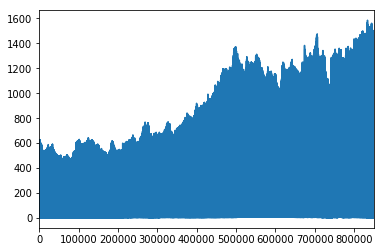

In [164]:
prices['open'].plot()
plt.show()

But this graph is useless! Let's just focus on ONE company, say Willis Towers Watson (`WLTW`):

In [165]:
wltw_df = prices[prices['symbol'] == 'WLTW']

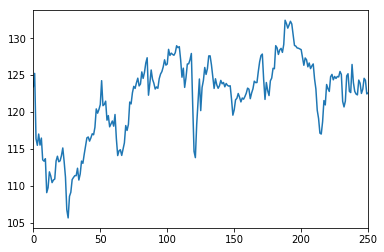

In [166]:
wltw_df['open'].plot()
plt.show()